## Importar librerias y definición de la ruta  de trabajo (path)

In [1]:

import pandas as pd
import numpy as np
import os
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

%matplotlib inline

# Tratamiento de datos
# ==============================================================================
import shap
from skforecast.utils import load_forecaster
from skforecast.utils import save_forecaster
from skforecast.preprocessing import RollingFeatures
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import TimeSeriesFold
from skforecast.direct import ForecasterDirect
from skforecast.recursive import ForecasterRecursive
import skforecast
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import sklearn
from skforecast.datasets import fetch_dataset

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# Modelado y Forecasting
# ==============================================================================


# Configuración warnings
# ==============================================================================
warnings.filterwarnings('once')

color = '\033[1m\033[38;5;208m'
print(f"{color}Versión skforecast: {skforecast.__version__}")
print(f"{color}Versión scikit-learn: {sklearn.__version__}")
print(f"{color}Versión pandas: {pd.__version__}")
print(f"{color}Versión numpy: {np.__version__}")

# Formato de los prints
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

def headr(text):
    return ('\n'+color.UNDERLINE + text + color.END+'\n')


Versión skforecast: 0.15.1
Versión scikit-learn: 1.6.1
Versión pandas: 2.2.3
Versión numpy: 1.26.4


In [2]:
# Ingresa la ruta donde está el repositorio
ruta = 'c:/repo_remoto/'

## Preprocesado

In [3]:
mantenimiento_df = pd.read_csv(ruta + 'Etapa4/output/merge_df.csv')

In [11]:
mantenimiento_df_1 = mantenimiento_df[mantenimiento_df['ID_Equipo'] == 2].copy()
mantenimiento_df_1

,Fecha,ID_Equipo,Tipo_Mantenimiento,Ubicacion,Temperatura_C,Vibracion_mm_s,Horas_Operativas,Tipo_Equipo,Fabricante,Modelo,Potencia_kW,Horas_Recomendadas_Revision
1,2021-01-01,2,Preventivo,Ubicacion_A,46.619128,5.462178,219,Compresor,Fabricante_B,Modelo_3,495,550
501,2021-01-02,2,Preventivo,Ubicacion_A,27.325772,2.169030,241,Compresor,Fabricante_B,Modelo_3,495,550
1001,2021-01-03,2,Preventivo,Ubicacion_A,59.782044,2.766126,249,Compresor,Fabricante_B,Modelo_3,495,550
1501,2021-01-04,2,Preventivo,Ubicacion_A,28.018631,9.115977,260,Compresor,Fabricante_B,Modelo_3,495,550
2001,2021-01-05,2,Preventivo,Ubicacion_A,60.604635,7.734923,272,Compresor,Fabricante_B,Modelo_3,495,550
...,...,...,...,...,...,...,...,...,...,...,...,...
729248,2024-12-27,2,Preventivo,Ubicacion_A,47.881532,9.801241,139,Compresor,Fabricante_B,Modelo_3,495,550
729748,2024-12-28,2,Preventivo,Ubicacion_A,31.870169,5.820973,156,Compresor,Fabricante_B,Modelo_3,495,550
730248,2024-12-29,2,Preventivo,Ubicacion_A,47.672791,3.379649,170,Compresor,Fabricante_B,Modelo_3,495,550
730748,2024-12-30,2,Preventivo,Ubicacion_A,44.255879,3.194149,179,Compresor,Fabricante_B,Modelo_3,495,550


In [12]:
mantenimiento_df_1['Fecha'] = pd.to_datetime(mantenimiento_df_1['Fecha'], format='%Y-%m-%d')
mantenimiento_df_1 = mantenimiento_df_1.set_index('Fecha')

In [14]:
# Eliminar duplicados en el índice para evitar errores
mantenimiento_df_1 = mantenimiento_df_1[~mantenimiento_df_1.index.duplicated(keep='first')]

mantenimiento_df_1 = mantenimiento_df_1.asfreq('D')  # Convierte Timeseries a frecuencia especificada.
mantenimiento_df_1 = mantenimiento_df_1.sort_index()

In [15]:
# Sumatorio de filas duplicadas en mantenimiento_df
print("Sumatorio de filas duplicadas en mantenimiento_df:", mantenimiento_df_1.duplicated().sum())

Sumatorio de filas duplicadas en mantenimiento_df: 0


In [16]:
print(f'Número de filas con missing values: {mantenimiento_df_1.isnull().any(axis=1).mean()}')

Número de filas con missing values: 0.0


In [17]:
# Verificar que un índice temporal está completo

fecha_inicio = mantenimiento_df_1.index.min()
fecha_fin = mantenimiento_df_1.index.max()
date_range_completo = pd.date_range(start=fecha_inicio, end=fecha_fin, freq=mantenimiento_df_1.index.freq)

print(f"Índice completo: {(mantenimiento_df_1.index == date_range_completo).all()}")

Índice completo: True


In [18]:
mantenimiento_df_1

,ID_Equipo,Tipo_Mantenimiento,Ubicacion,Temperatura_C,Vibracion_mm_s,Horas_Operativas,Tipo_Equipo,Fabricante,Modelo,Potencia_kW,Horas_Recomendadas_Revision
Fecha,,,,,,,,,,,
2021-01-01,2,Preventivo,Ubicacion_A,46.619128,5.462178,219,Compresor,Fabricante_B,Modelo_3,495,550
2021-01-02,2,Preventivo,Ubicacion_A,27.325772,2.169030,241,Compresor,Fabricante_B,Modelo_3,495,550
2021-01-03,2,Preventivo,Ubicacion_A,59.782044,2.766126,249,Compresor,Fabricante_B,Modelo_3,495,550
2021-01-04,2,Preventivo,Ubicacion_A,28.018631,9.115977,260,Compresor,Fabricante_B,Modelo_3,495,550
2021-01-05,2,Preventivo,Ubicacion_A,60.604635,7.734923,272,Compresor,Fabricante_B,Modelo_3,495,550
...,...,...,...,...,...,...,...,...,...,...,...
2024-12-27,2,Preventivo,Ubicacion_A,47.881532,9.801241,139,Compresor,Fabricante_B,Modelo_3,495,550
2024-12-28,2,Preventivo,Ubicacion_A,31.870169,5.820973,156,Compresor,Fabricante_B,Modelo_3,495,550
2024-12-29,2,Preventivo,Ubicacion_A,47.672791,3.379649,170,Compresor,Fabricante_B,Modelo_3,495,550


In [19]:
# Elimino ID_Orden, establezco Fecha como índice y le doy formato datetime
mantenimiento_df_1 = mantenimiento_df_1.drop(
    columns=['ID_Equipo','Ubicacion', 'Tipo_Equipo', 'Fabricante', 'Modelo', 'Potencia_kW', 'Horas_Recomendadas_Revision'])

In [20]:
mantenimiento_df_1

,Tipo_Mantenimiento,Temperatura_C,Vibracion_mm_s,Horas_Operativas
Fecha,,,,
2021-01-01,Preventivo,46.619128,5.462178,219
2021-01-02,Preventivo,27.325772,2.169030,241
2021-01-03,Preventivo,59.782044,2.766126,249
2021-01-04,Preventivo,28.018631,9.115977,260
2021-01-05,Preventivo,60.604635,7.734923,272
...,...,...,...,...
2024-12-27,Preventivo,47.881532,9.801241,139
2024-12-28,Preventivo,31.870169,5.820973,156
2024-12-29,Preventivo,47.672791,3.379649,170


In [21]:
from sklearn.preprocessing import LabelEncoder

# Crear un codificador para la columna Tipo_Mantenimiento
label_encoder = LabelEncoder()

# Transformar la columna Tipo_Mantenimiento en valores numéricos
mantenimiento_df_1['Tipo_Mantenimiento'] = label_encoder.fit_transform(mantenimiento_df_1['Tipo_Mantenimiento'])

# Verificar la transformación
mantenimiento_df_1

,Tipo_Mantenimiento,Temperatura_C,Vibracion_mm_s,Horas_Operativas
Fecha,,,,
2021-01-01,1,46.619128,5.462178,219
2021-01-02,1,27.325772,2.169030,241
2021-01-03,1,59.782044,2.766126,249
2021-01-04,1,28.018631,9.115977,260
2021-01-05,1,60.604635,7.734923,272
...,...,...,...,...
2024-12-27,1,47.881532,9.801241,139
2024-12-28,1,31.870169,5.820973,156
2024-12-29,1,47.672791,3.379649,170


Fechas train : 2021-01-01 00:00:00 --- 2024-12-16 00:00:00  (n=1446)
Fechas test  : 2024-12-17 00:00:00 --- 2024-12-31 00:00:00  (n=15)


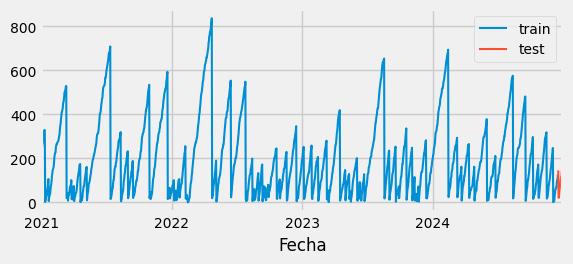

In [682]:
# Separación datos train-test

steps = 15
datos_train = mantenimiento_df_1[:-steps]
datos_test  = mantenimiento_df_1[-steps:]
print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

fig, ax = plt.subplots(figsize=(6, 2.5))
datos_train['Horas_Operativas'].plot(ax=ax, label='train')
datos_test['Horas_Operativas'].plot(ax=ax, label='test')
ax.legend();

In [779]:
# Crear y entrenar forecaster

forecaster = ForecasterRecursive(
    regressor=Ridge(random_state=123),
    lags=2
    )

exogs_train = datos_train.drop(columns=['Horas_Operativas'])

forecaster.fit(y=datos_train['Horas_Operativas'], exog=exogs_train)
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: Ridge 
Lags: [1 2] 
Window features: None 
Window size: 2 
Exogenous included: True 
Exogenous names: Tipo_Mantenimiento, Temperatura_C, Vibracion_mm_s 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2021-01-01 00:00:00'), Timestamp('2024-12-16 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: 
    {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None,
    'positive': False, 'random_state': 123, 'solver': 'auto', 'tol': 0.0001} 
fit_kwargs: {} 
Creation date: 2025-04-25 09:33:32 
Last fit date: 2025-04-25 09:33:32 
Skforecast version: 0.15.1 
Python version: 3.10.11 
Forecaster id: None

In [780]:
# Predicciones
exogs_test = datos_test.drop(columns=['Horas_Operativas'])

predicciones = forecaster.predict(steps=steps, exog=exogs_test)
predicciones.head(5)

2024-12-17    144.025352
2024-12-18    -47.958057
2024-12-19    -19.478367
2024-12-20      7.779319
2024-12-21     33.403263
Freq: D, Name: pred, dtype: float64

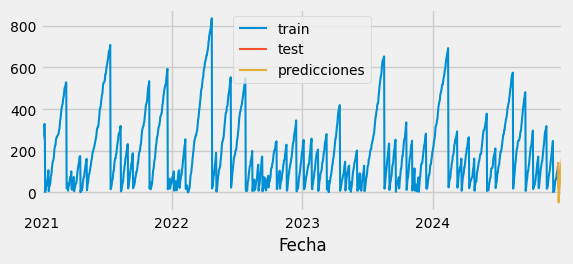

In [781]:
# Gráfico de predicciones vs valores reales

fig, ax = plt.subplots(figsize=(6, 2.5))
datos_train['Horas_Operativas'].plot(ax=ax, label='train')
datos_test['Horas_Operativas'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend()

In [782]:
# Error test
error_mse = mean_squared_error(
    y_true=datos_test['Horas_Operativas'],
    y_pred=predicciones
)

# Varianza de los valores reales
varianza = datos_test['Horas_Operativas'].var()

print(f"Error de test (mse): {error_mse}")
print(f"Varianza de los valores reales: {varianza}")

Error de test (mse): 742.0167638853194
Varianza de los valores reales: 3158.6952380952375


In [783]:
# Specify the step for which you want to calculate feature importances
# step = 1  # Replace with the desired step number
importancia = forecaster.get_feature_importances()
importancia

,feature,importance
2,Tipo_Mantenimiento,208.060169
0,lag_1,0.935330
4,Vibracion_mm_s,0.653054
3,Temperatura_C,-0.002478
1,lag_2,-0.006966


In [791]:
# Búsqueda de hiperparámetros

from skforecast.exceptions import LongTrainingWarning
warnings.simplefilter('ignore', category=LongTrainingWarning)

forecaster = ForecasterRecursive(
    regressor=Ridge(random_state=123),
    lags=2  # Este valor será remplazado en el grid search
)

cv = TimeSeriesFold(
    steps=15,
    initial_train_size=int(len(datos_train) * 0.5),
    fixed_train_size=False,
    refit=False,
)

param_grid = {'alpha': np.logspace(-5, 5, 10)}

lags_grid = [2, 100]

resultados_grid = grid_search_forecaster(
    forecaster=forecaster,
    y=datos_train['Horas_Operativas'],
    cv=cv,
    param_grid=param_grid,
    lags_grid=lags_grid,
    metric='mean_squared_error',
    return_best=True,
    n_jobs='auto',
    verbose=False
)

lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2] 
  Parameters: {'alpha': 1e-05}
  Backtesting metric: 14246.386721014822


In [792]:
# Crear y entrenar forecaster

forecaster = ForecasterRecursive(
    regressor=Ridge(alpha= 1, random_state=123),
    lags=2
    )

exogs_train = datos_train.drop(columns=['Horas_Operativas'])

forecaster.fit(y=datos_train['Horas_Operativas'], exog=exogs_train)
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: Ridge 
Lags: [1 2] 
Window features: None 
Window size: 2 
Exogenous included: True 
Exogenous names: Tipo_Mantenimiento, Temperatura_C, Vibracion_mm_s 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2021-01-01 00:00:00'), Timestamp('2024-12-16 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: 
    {'alpha': 1, 'copy_X': True, 'fit_intercept': True, 'max_iter': None,
    'positive': False, 'random_state': 123, 'solver': 'auto', 'tol': 0.0001} 
fit_kwargs: {} 
Creation date: 2025-04-25 09:34:36 
Last fit date: 2025-04-25 09:34:36 
Skforecast version: 0.15.1 
Python version: 3.10.11 
Forecaster id: None

In [793]:
# Predicciones

exogs_test = datos_test.drop(columns=['Horas_Operativas'])

predicciones = forecaster.predict(steps=steps, exog=exogs_test)

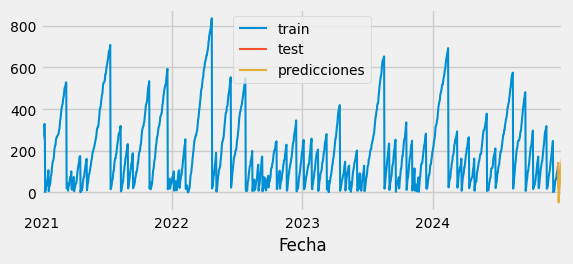

In [794]:
# Predicciones

predicciones = forecaster.predict(steps=steps, exog=exogs_test)

# Gráfico predicciones vs valores reales

fig, ax = plt.subplots(figsize=(6, 2.5))
datos_train['Horas_Operativas'].plot(ax=ax, label='train')
datos_test['Horas_Operativas'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [795]:
# Error test
error_mse = mean_squared_error(
    y_true=datos_test['Horas_Operativas'],
    y_pred=predicciones
)

# Varianza de los valores reales
varianza = datos_test['Horas_Operativas'].var()

print(f"Error de test (mse): {error_mse}")
print(f"Varianza de los valores reales: {varianza}")

Error de test (mse): 742.0167638853194
Varianza de los valores reales: 3158.6952380952375


In [796]:
# Backtesting

cv = TimeSeriesFold(
    steps=5 * 3,
    initial_train_size=len(datos_train) - 12 * 9,
    fixed_train_size=False,
    refit=True,
)

metrica, predicciones_backtest = backtesting_forecaster(
    forecaster=forecaster,
    y=datos_train['Horas_Operativas'],
    cv=cv,
    metric='mean_squared_error',
    verbose=True
)
metrica

Information of folds
--------------------
Number of observations used for initial training: 1338
Number of observations used for backtesting: 108
    Number of folds: 8
    Number skipped folds: 0 
    Number of steps per fold: 15
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 3 observations.

Fold: 0
    Training:   2021-01-01 00:00:00 -- 2024-08-30 00:00:00  (n=1338)
    Validation: 2024-08-31 00:00:00 -- 2024-09-14 00:00:00  (n=15)
Fold: 1
    Training:   2021-01-01 00:00:00 -- 2024-09-14 00:00:00  (n=1353)
    Validation: 2024-09-15 00:00:00 -- 2024-09-29 00:00:00  (n=15)
Fold: 2
    Training:   2021-01-01 00:00:00 -- 2024-09-29 00:00:00  (n=1368)
    Validation: 2024-09-30 00:00:00 -- 2024-10-14 00:00:00  (n=15)
Fold: 3
    Training:   2021-01-01 00:00:00 -- 2024-10-14 00:00:00  (n=1383)
    Validation: 2024-10-15 00:00:00 -- 2024-10-29 00:00:00  (n=15)
Fold: 4
    Training:   2021-01-01 00:00:00 -- 2024

  0%|          | 0/8 [00:00<?, ?it/s]

,mean_squared_error
0,21339.707117


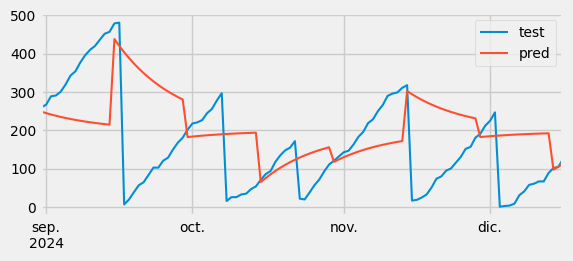

In [797]:
# Gráfico de predicciones de backtest vs valores reales

fig, ax = plt.subplots(figsize=(6, 2.5))
mantenimiento_df_1.loc[predicciones_backtest.index, 'Horas_Operativas'].plot(ax=ax, label='test')
predicciones_backtest.plot(ax=ax, label='predicciones')
ax.legend()